## Uncertainty Quantifications - Monte Carlo Simulations

---

This notebook will quantify log k values for various species using a Monte Carlo method with lower and upper bounds from literature. See below:

Mahoney et al. (2009). Uranyl Adsorption on to Hydrous Ferric Oxcide--A Re-Evaluation for the Diffuse Layer Model Database. *Environmental Science and Technology,* *43*(24), 9263. doi: 10.1021/es901586w

#### Set up initial parameters and uncertainty bounds

*pqcpath*: path to phreeqc.bat executable

*TDBfile*: name of phreeqc database file without file extension

*outfile*: name of phreeqc output file including file extension

*infile*: name of phreeqc input file including file extension

In [1]:
import os 
import numpy.random
from writeIOphreeqc import*
import matplotlib.pyplot as plt

# these are used when we run phreeqc in run_sims()
pqcpath = 'C:/Users/htzen/Desktop/phreeqc-3.7.0-15749-x64/bin/phreeqc'
TDBfile = 'llnl_Mahoney_updated'
outfile = 'Outputfile3.out'
infile = 'U_HFO_input3.txt'

# bounds from table 2 in Mahoney et. al.
pars    = ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!']
lower = [1.62, 1.79, 8.75, 15.1]
upper = [5.85, 3.28, 9.32, 15.28]

# setting up values from experimental results for later plotting
exp_pH = [3.56041,4.07969,4.51985,5.00029,5.47929,5.93959]
exp_U = [0.099831,0.071537,0.029899,0.001774,0,0]


# extraneous verify function which can be a simple sanity check for longer lists
def verify(low, upp):
    """
    checks length and bounds of lists for correct format
    """
    if len(low) == len(upp):
        
        if all([low[i] <= upp[i] for i in range(len(low))]):
            print("verify: bounds check out")
            return True
        print("verify: error -- listed bounds are inconsistent")
        return False
    
    print("verify: error -- lists are different lenghts")
    return False



# searches for the '-find ' key in the input file to get the name of the .sel output file
# (assumes .sel file is in the current directory)
def find_opsel(infile):
    
    with open(infile, 'r') as f:
        for line in f.readlines():
            if line.find("-file ") > 0:
                return line[line.find("-file ")+len("-file "):-1]
            
    print("error: unable to find output file in {}".format(infile))
    return -1


#### Define methods for Monte Carlo simulation

In a Monte Carlo simulation we will generate random values for the parameters within the upper/lower bounds for each run

In [2]:
# returns a matrix of random values between lower and upper
def get_random_values(lower, upper, num_iter):
    # lower, upper: lists of bounds to generate within
    # num_iter: number of sets to generate
    # return: num_iter by len(lower) matrix
    
    # generate 1 row
    matrix = np.zeros(len(lower))
    for i in range(len(lower)):
        matrix[i] = numpy.random.uniform(lower[i], upper[i])
        
    # generate more rows if needed
    if num_iter < 2:
        return [matrix]
    else:
        for j in range(num_iter-1):
            values = np.zeros(len(lower))
            for i in range(len(lower)):
                values[i] = numpy.random.uniform(lower[i], upper[i])
            matrix = np.vstack((matrix, values))
        return matrix

# runs a phreeqc simulation for each row of parameters in values_mtrx
# requires various path variables to be set correctly at beginning of file
def run_sims(values_mtrx, opsel, analytes=['pH', 'U']):
    # values_mtrx: matrix of values generated from get_random_values or similar function
    # analytes: list of element keywords to search for in .out file generated by phreeqc
    # opsel: path to the .sel file  
    # return: list of np arrays of [sim#, analyte1, analyte2...] (format is kind of awkward 
    #    but I can handle it with wrapper functions for now)
    
    obs_all = []
    for values in values_mtrx:        
        # enabling the below code can help verify phreeqc is correctly generating new output files
        # by deleting old output files before each run
#         if os.path.exists("Outputfile.out"):
#             os.remove("Outputfile.out")
#         if os.path.exists("U_HFO_Complexation_Output_Trial3.sel"):
#             os.remove("U_HFO_Complexation_Output_Trial3.sel")

        writeInput(TDBfile, pars, values)
        
        # the .read() here is essential because it tells python to wait for phreeqc to
        # finish running before executing following code.
        os.popen(pqcpath+' '+infile+' '+outfile+' '+TDBfile+'.txt').read()
        
        # reads phreeqc results and appends to running list
        obs = readOutput(opsel, analytes)
        obs_all.append(obs)

        # enabling following code can help check if the output files are updating correctly
#         import shutil
#         shutil.copyfile('U_HFO_Complexation_Output_Trial3.sel', 'U_HFO_Complexation_Output_Trial3_{}.sel'.format(itr))
#         shutil.copyfile('llnl_Mahoney_updated.txt', 'llnl_Mahoney_updated{}.txt'.format(itr))

    return obs_all


In [3]:
# verify bounds and set phreeqc output to read
verify(lower, upper)
opsel = find_opsel(infile)
#print(opsel)
gen_values = get_random_values(lower, upper, 9)
res = run_sims(gen_values, opsel)

verify: bounds check out


In [6]:
res

[array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.4558e-08, 6.2119e-08, 1.8642e-08, 3.0358e-09, 7.2546e-10,
         4.0270e-10]]),
 array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.8971e-08, 9.0664e-08, 5.7723e-08, 1.5736e-08, 4.1773e-09,
         2.3546e-09]]),
 array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.7776e-08, 8.0930e-08, 3.7293e-08, 7.5225e-09, 1.8636e-09,
         1.0397e-09]]),
 array([[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400

#### Plotting + Residual Sum of Squares Analysis with Experimental Results

For each run from run_sims that we did we can plot pH vs Uranium concentrations in micromoles, and compare to experimental results to find the run with the least RSS value

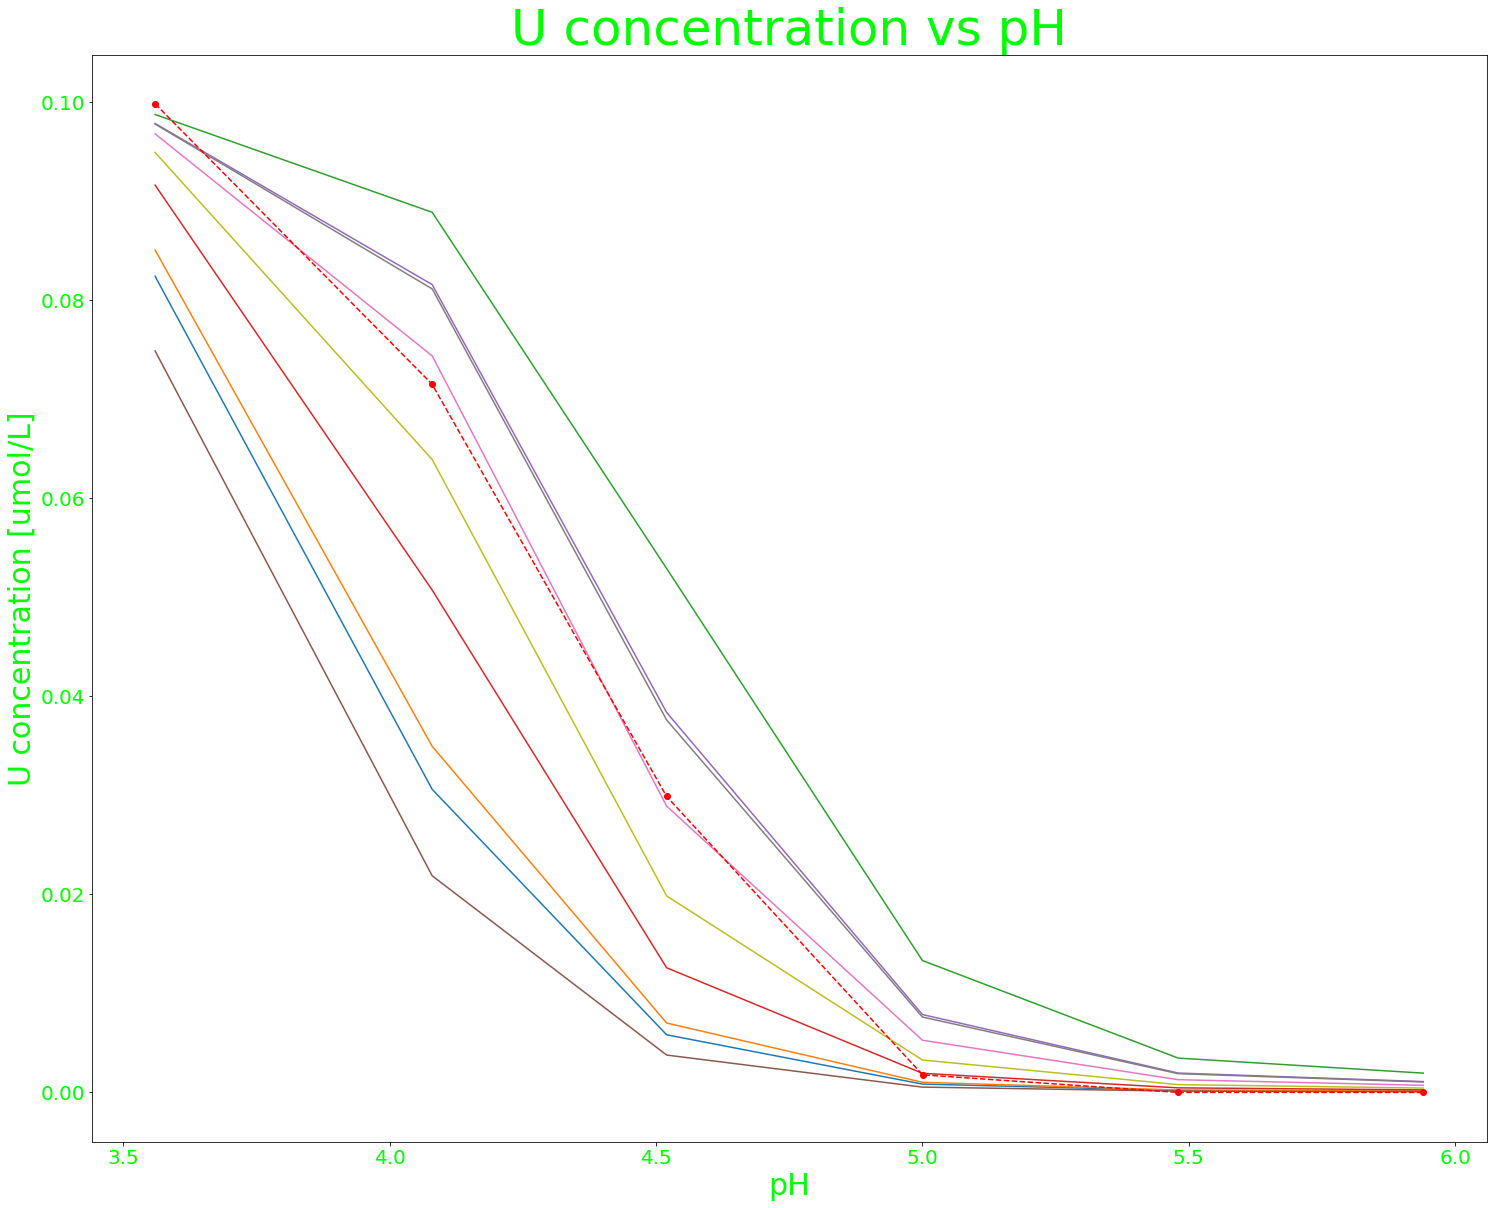

In [4]:
f = plt.figure(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("U concentration vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('U concentration [umol/L]', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

# plotting each data from run_sims
for run in res:
    # hard coding in plots for pH and U
    plt.plot(run[1], run[2]*1e6)

# plotting experimental results for reference
plt.plot(exp_pH, exp_U, 'r--o')

plt.show()

For RSS analysis I think the best thing to do in this situation is to just hard-code something instead of making more comprehensive functions, since the experimental data in this case seems tailor-fit for this specific scenario. I will iterate through the list of results and find a quick residual sum of squares for each pH (approximating the pHes because they're already really close)

In [8]:
rss_list = []

for run in res:
    # rss is Sum((expected - observed)^2)
    rss = np.sum(np.square(exp_U - run[2]*1e6))
    rss_list.append(rss)

bestrun = rss_list.index(min(rss_list))
bestfit = res[rss_list.index(min(rss_list))][2]
bestanalytes = gen_values[bestrun]

print(rss_list)
print(min(rss_list), bestrun)
print("The best fitting analytes are: {} from run {}.".format(bestanalytes, bestrun))

# write a new .tpl file with the best fit analyte values
writeInput(TDBfile, pars, bestanalytes, TDBfile+"_MCnew")

[0.00024550390074160007, 0.00135868812545, 0.0001847219433, 0.000124083497187, 3.931797947000004e-05, 0.0014801044406284002, 0.00018046777293529982, 0.0028644880992600014, 0.0002104925412501001]
3.931797947000004e-05 4
The best fitting analytes are: [ 1.81441436  2.94687808  9.0562998  15.18881105] from run 4.


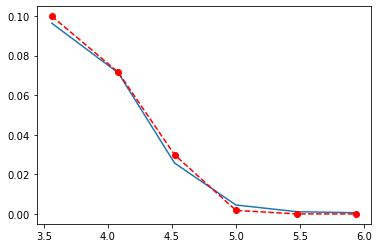

In [9]:
plt.plot(res[0][1], bestfit*1e6, exp_pH, exp_U, 'r--o')
plt.show()

#### Sensitivity Analysis

We will use the morris analysis functions from the Sensitivity Analysis Library package to find which of the four initial parameters are the most significant

---
large mean (mu) = large response to perturbation

large sigma = elementary effects depend highly on choice of sample point (response is non-linear)

small sigma = EEs similar for different selected sample points; effect of parameter independent of other parameter values

In [3]:
from SALib.sample import morris as ssm
from SALib.analyze import morris as sam

# Define the model inputs
problem = {
    'num_vars': 4,
    'names': ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!'],
    'bounds': [[1.62, 5.85], [1.79, 3.28], [8.75, 9.32], [15.2, 15.28]]
}


# runs run_sims and formats analyte results into matrix of iteration# and observation
# save matrix results into file
# write function to load file later
def ensemble_sim(params, opsel, analyte=['U'], savefile=''):
    # analyte: single analyte to measure; name of colummn from phreeqc .sel output file
    # savefile: saves results array to a .npy file. needs to contain '.npy' in name
    #    also saves params array as 'savefile_p.npy'
    # return: #simulations by #observations matrix

    sims = run_sims(params, opsel, analyte)
    
    # [0][1] index of run_sims will be the list of analyte values 
    output = sims[0][1]
    for sim in sims[1:]:
        output = np.vstack((output, sim[1]))
    
    if savefile:
        if ".npy" in savefile:
            np.save(savefile, output)
            sfp = savefile.split(".npy")[0]+"_p.npy"
            np.save(sfp, params)
        else:
            print("error: savefile name \"{}\" does not contain '.npy': Results not saved."\
                  .format(savefile))
    
    return output

def load_sim(savefile):
    if ".npy" not in savefile:
        print("error: file name \"{}\" does not contain '.npy'".format(savefile))
        return
    return np.load(savefile)

# generates a list of morris result dictionaries per parameter
def morris_analysis(X, Y):
    # Perform Morris analysis on first parameter
    morris_result = [sam.analyze(problem, X, Y.T[0], conf_level=0.95, num_levels=4,
                         print_to_console=False)]

    # Storing the sensitivity indices as a list of dictionaries
    # each dictionary represents the results for one observation
    for i_obs in range(1, np.shape(Y)[1]):
        Si = sam.analyze(problem, X, Y.T[i_obs], conf_level=0.95, num_levels=4, 
                         print_to_console=False)
        morris_result.append(Si)

#     # Making a matrix of observations by parameters
#     mu_all = morris_result[0].get("mu")
#     for obs in morris_result[1:]:
#         mu_all = np.vstack((mu_all, obs.get("mu")))
        
    return morris_result


def dicts_to_mtrx(dlist, key):
    # helper function to convert SALib dictionary results back into matrices
    mtrx = dlist[0].get(key)
    for d in dlist[1:]:
        mtrx = np.vstack((mtrx, d.get(key)))
    return mtrx

def morris_summary(morris_res):
    # returns mean EE, mean abs EE, and STD of (parameter, simulation) from phreeqc
    return dicts_to_mtrx(morris_res, "mu").T, dicts_to_mtrx(morris_res, "mu_star").T, \
        dicts_to_mtrx(morris_res, "sigma").T

In [4]:
# Generate samples according to the morris method
# in this case it's 20*(num_vars+1) sets of 4 parameters within the bounds
num_traj = 20
# X = ssm.morris.sample(problem, num_traj)
X = load_sim("7_19sim_p.npy")

# Calculate model outputs
# Y = ensemble_sim(X, opsel, savefile="7_19sim.npy")
Y = load_sim("7_19sim.npy")

# generate results
morris_res = morris_analysis(X, Y)
morris_res

[{'names': ['!Hfo_sOUO2+!',
   '!Hfo_wOUO2+!',
   '!Hfo_wOUO2CO3-!',
   '!Hfo_wOUO2(CO3)2-3!'],
  'mu': array([-3.24993e-08, -6.18300e-09,  0.00000e+00,  0.00000e+00]),
  'mu_star': masked_array(data=[3.249930000000002e-08, 6.183000000000005e-09, 0.0, 0.0],
               mask=[False, False, False, False],
         fill_value=1e+20),
  'sigma': array([2.93577423e-08, 3.48159876e-09, 0.00000000e+00, 0.00000000e+00]),
  'mu_star_conf': masked_array(data=[1.2223301100386076e-08, 1.6095128291627207e-09, 0.0,
                     0.0],
               mask=[False, False, False, False],
         fill_value=1e+20)},
 {'names': ['!Hfo_sOUO2+!',
   '!Hfo_wOUO2+!',
   '!Hfo_wOUO2CO3-!',
   '!Hfo_wOUO2(CO3)2-3!'],
  'mu': array([-6.3889425e-08, -3.6885750e-08,  0.0000000e+00,  0.0000000e+00]),
  'mu_star': masked_array(data=[6.388942500000002e-08, 3.688575000000001e-08, 0.0, 0.0],
               mask=[False, False, False, False],
         fill_value=1e+20),
  'sigma': array([4.57068730e-08, 1.8998

In [5]:
ms = morris_summary(morris_res)
ms

(array([[-3.24993000e-08, -6.38894250e-08, -5.01810600e-08,
         -1.75957170e-08, -5.21550202e-09, -2.99735048e-09],
        [-6.18300000e-09, -3.68857500e-08, -5.76753600e-08,
         -2.66580360e-08, -8.39533245e-09, -4.87026870e-09],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -9.00000000e-14, -3.31500000e-13, -1.37647500e-12],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]),
 masked_array(
   data=[[3.24993000e-08, 6.38894250e-08, 5.01810600e-08, 1.75957170e-08,
          5.21550202e-09, 2.99735048e-09],
         [6.18300000e-09, 3.68857500e-08, 5.76753600e-08, 2.66580360e-08,
          8.39533245e-09, 4.87026870e-09],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.00000000e-14,
          3.31500000e-13, 1.37647500e-12],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00]],
   mask=False,
   fill_value=1

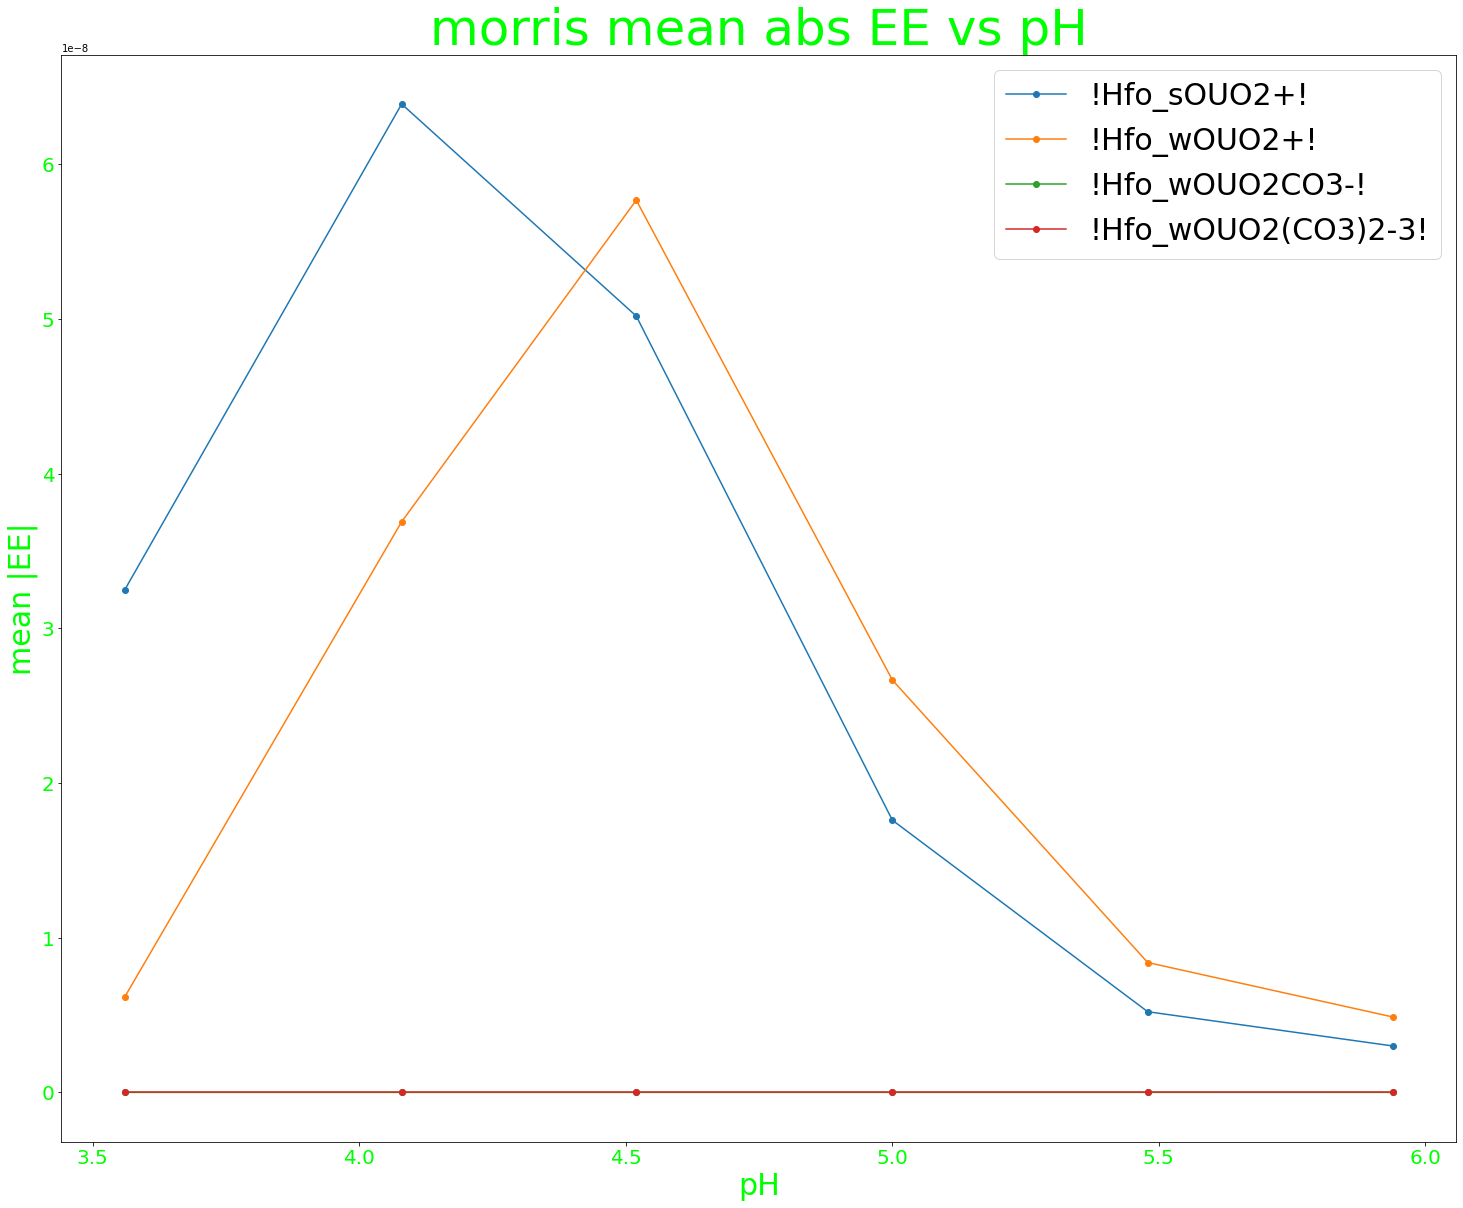

In [6]:
f = plt.figure(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("morris mean abs EE vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('mean |EE|', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(ms[1])):
    plt.plot(exp_pH, ms[1][i], marker='o', label="{}".format(pars[i]))
    plt.legend(fontsize=30)

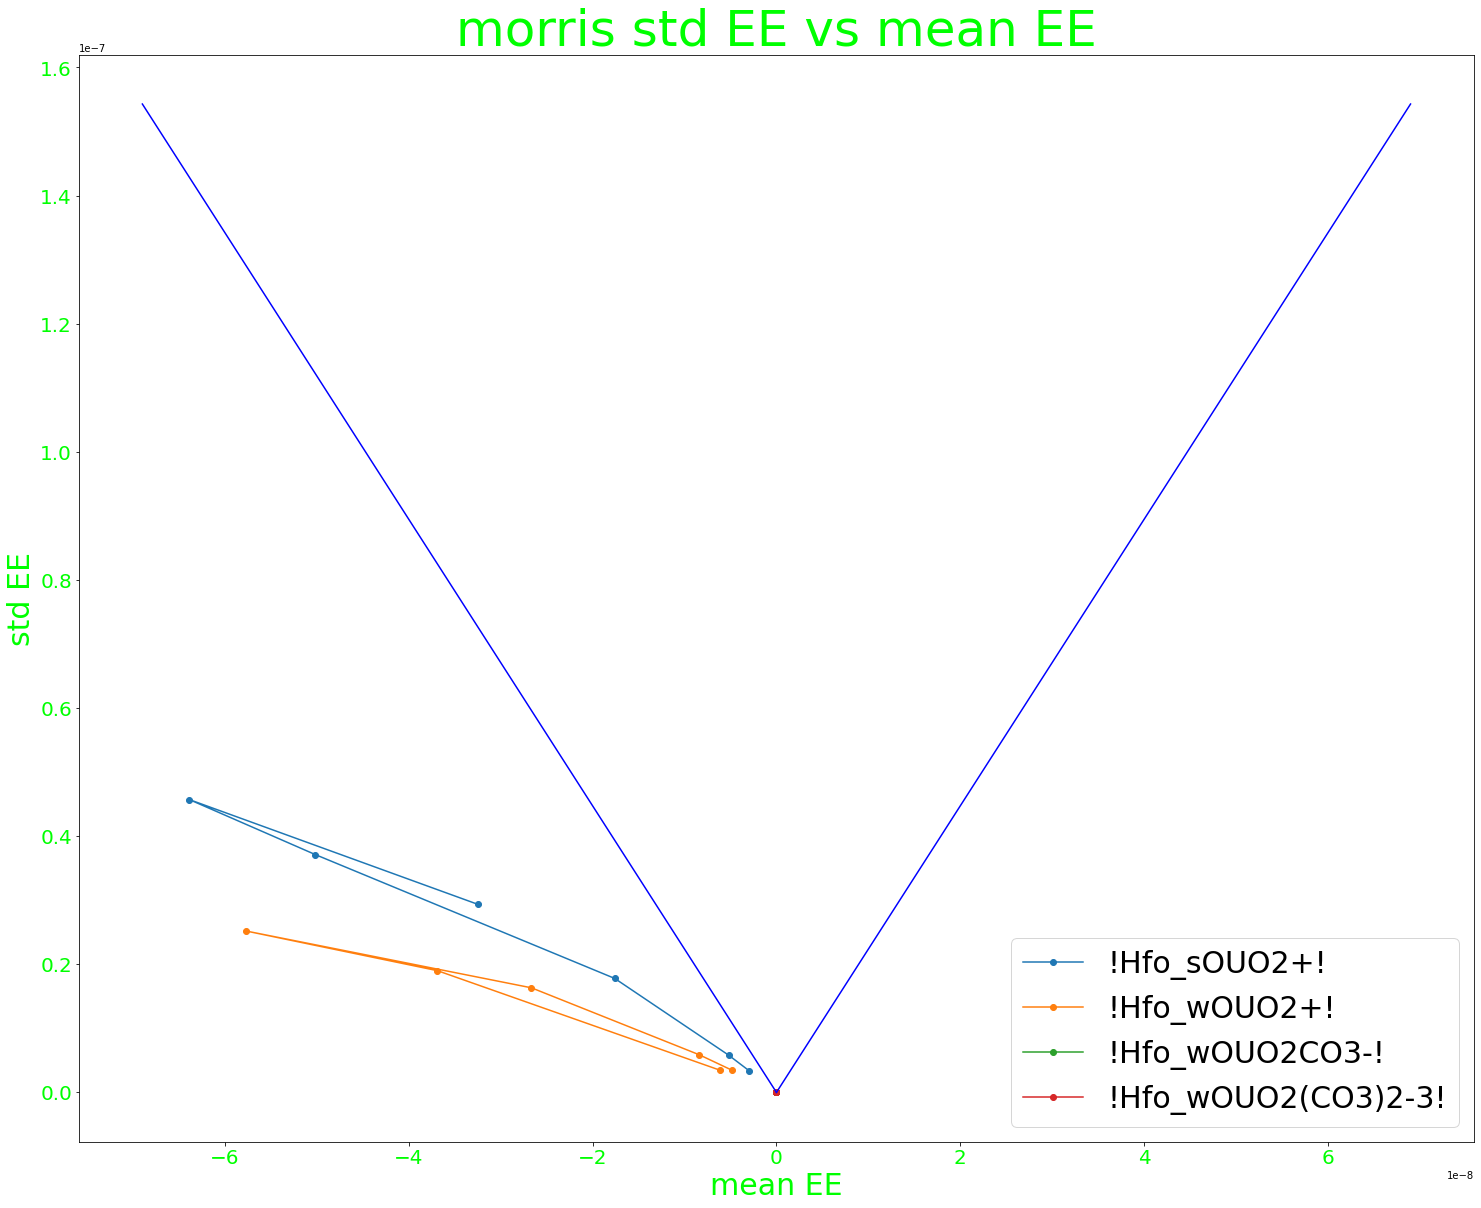

In [7]:
f, ax = plt.subplots(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("morris std EE vs mean EE", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('mean EE', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('std EE', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(ms[1])):
    plt.plot(ms[0][i], ms[2][i], marker='o', label="{}".format(pars[i]))
plt.legend(fontsize=30)

# plotting mean EE = +/- 2SEM line
# where SEM = std/sqrt(num_traj)
# note how in the corner of the graph the order of magnitude for mean EE is 1e-8
mean_range = np.arange(0, 7e-8, 0.1e-8)
plt.plot(mean_range, mean_range * np.sqrt(num_traj) / 2, 'b-')
plt.plot(mean_range * -1, mean_range * np.sqrt(num_traj) / 2, 'b-')
plt.show()

from a youtube video https://www.youtube.com/watch?v=P8Rfipkid3w:

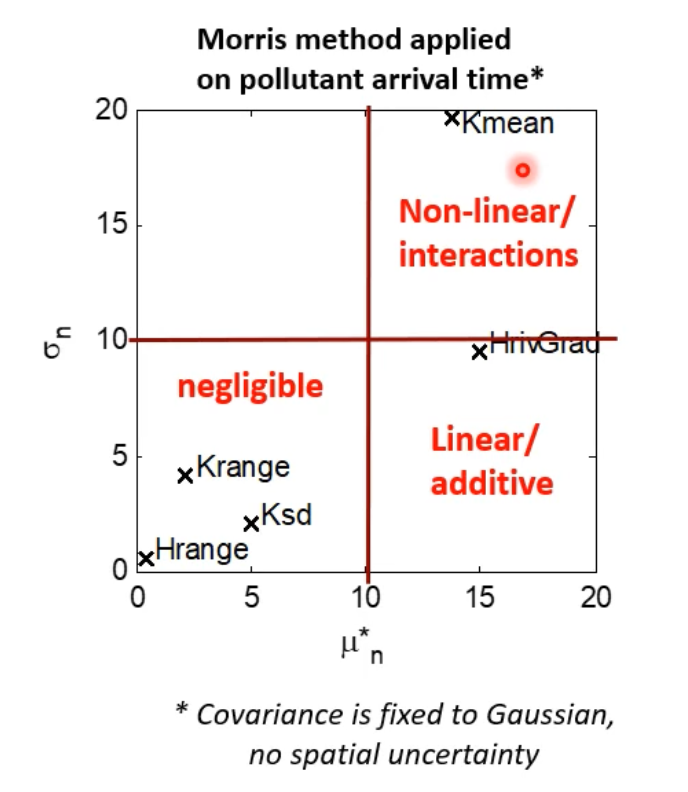

Now we will use the sobol method from the same library

In [8]:
from SALib.sample import saltelli as sss
from SALib.analyze import sobol as sas

def sobol_analysis(X, Y):
    # Perform sobol analysis on parameter 1
    sobol_result = [sas.analyze(problem, Y.T[0], conf_level=0.95, print_to_console=False)]

    # Storing the sensitivity indices as a list of dictionaries
    # each dictionary represents the results for one observation
    # returning this list instead gets a lot more information, but it might not
    # be necessary for now
    for i_obs in range(1, np.shape(Y)[1]):
        Si = sas.analyze(problem, Y.T[i_obs], conf_level=0.95, print_to_console=False)
        sobol_result.append(Si)
        
    return sobol_result

In [9]:
X = sss.sample(problem, 16)
X = load_sim("7_20sim_p.npy")
# Y = ensemble_sim(X, opsel, savefile="7_20sim.npy")
Y = load_sim("7_20sim.npy")
sr = sobol_analysis(X, Y)

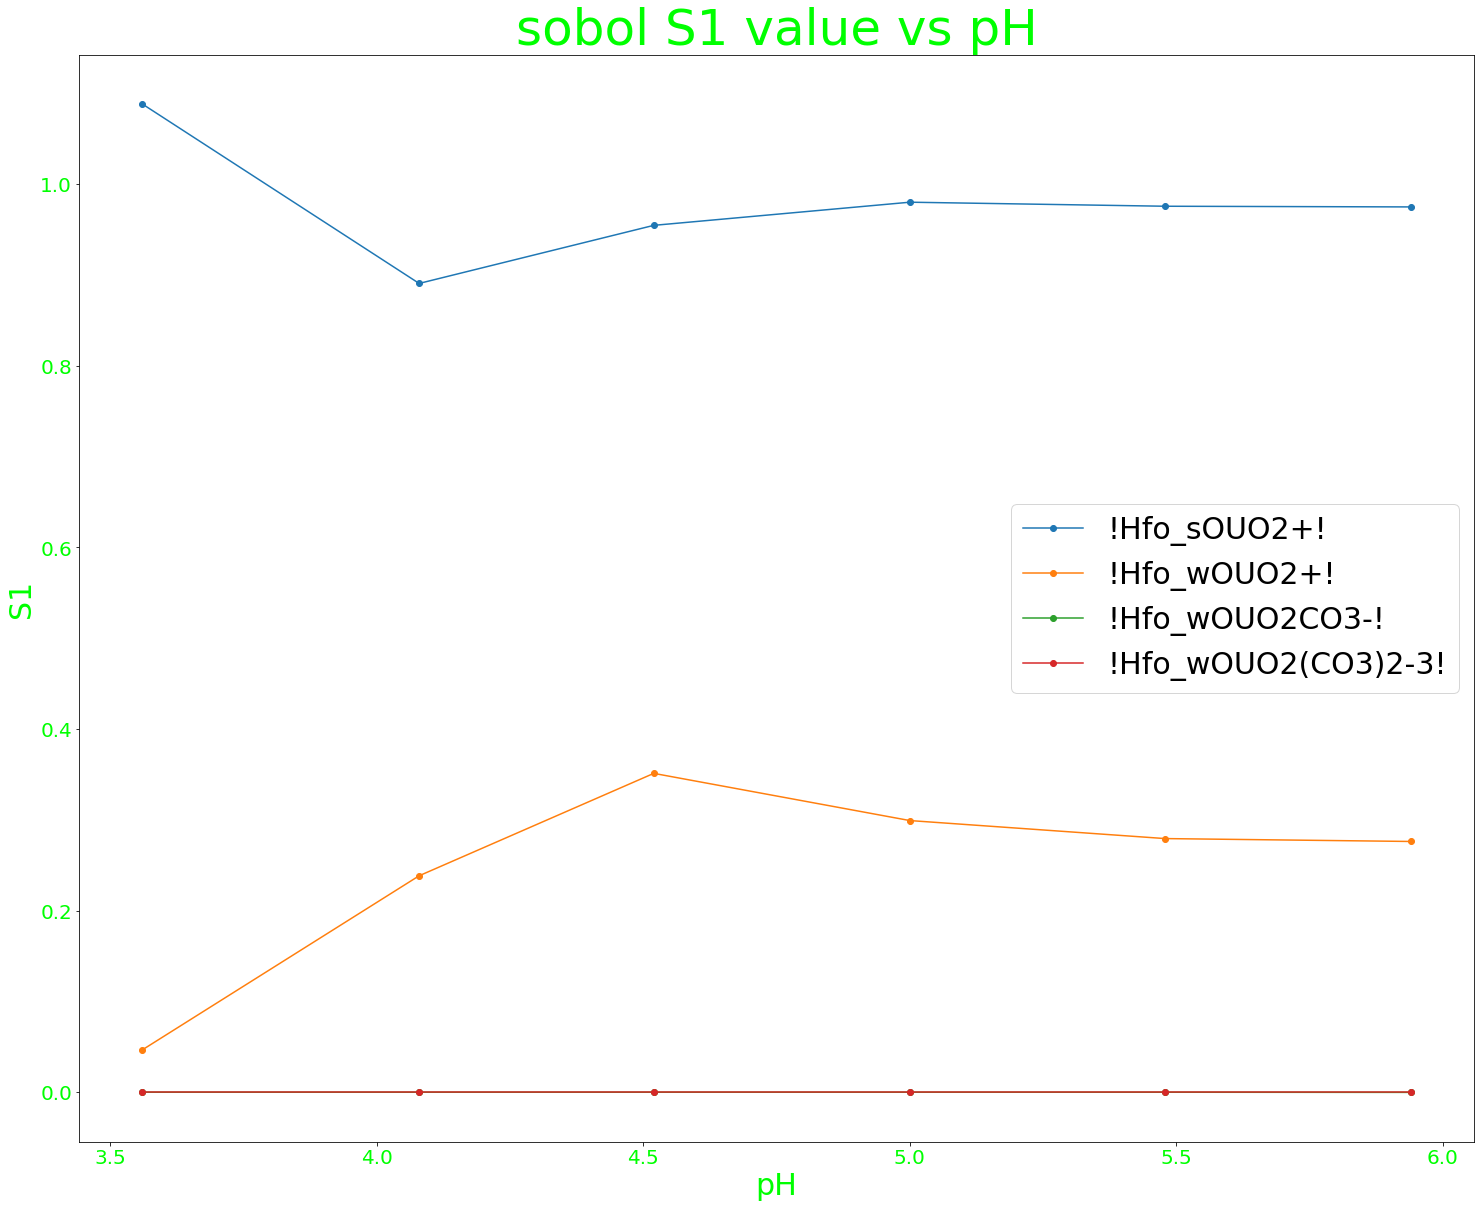

In [10]:
sb_s1 = dicts_to_mtrx(sr, "S1").T

f = plt.figure(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("sobol S1 value vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('S1', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(sb_s1)):
    plt.plot(exp_pH, sb_s1[i], marker='o', label="{}".format(pars[i]))
    plt.legend(fontsize=30)

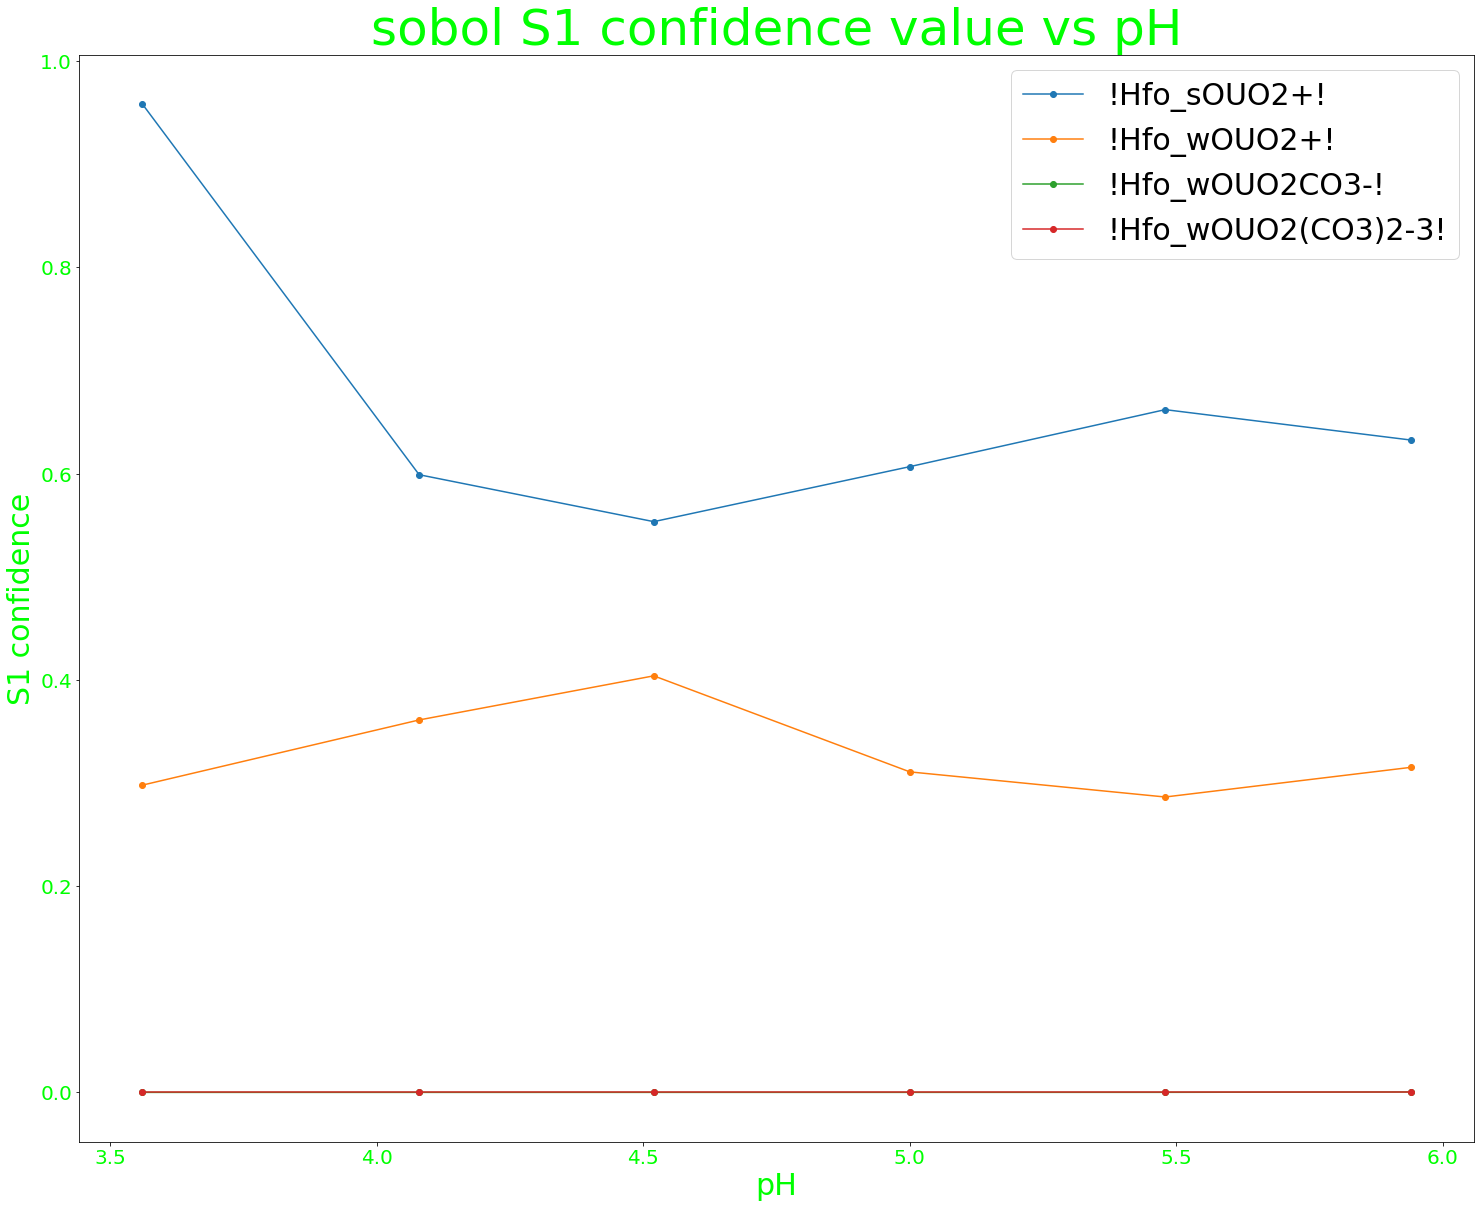

In [11]:
sb_st = dicts_to_mtrx(sr, "S1_conf").T

f = plt.figure(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("sobol S1 confidence value vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('S1 confidence', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(sb_st)):
    plt.plot(exp_pH, sb_st[i], marker='o', label="{}".format(pars[i]))
    plt.legend(fontsize=30)

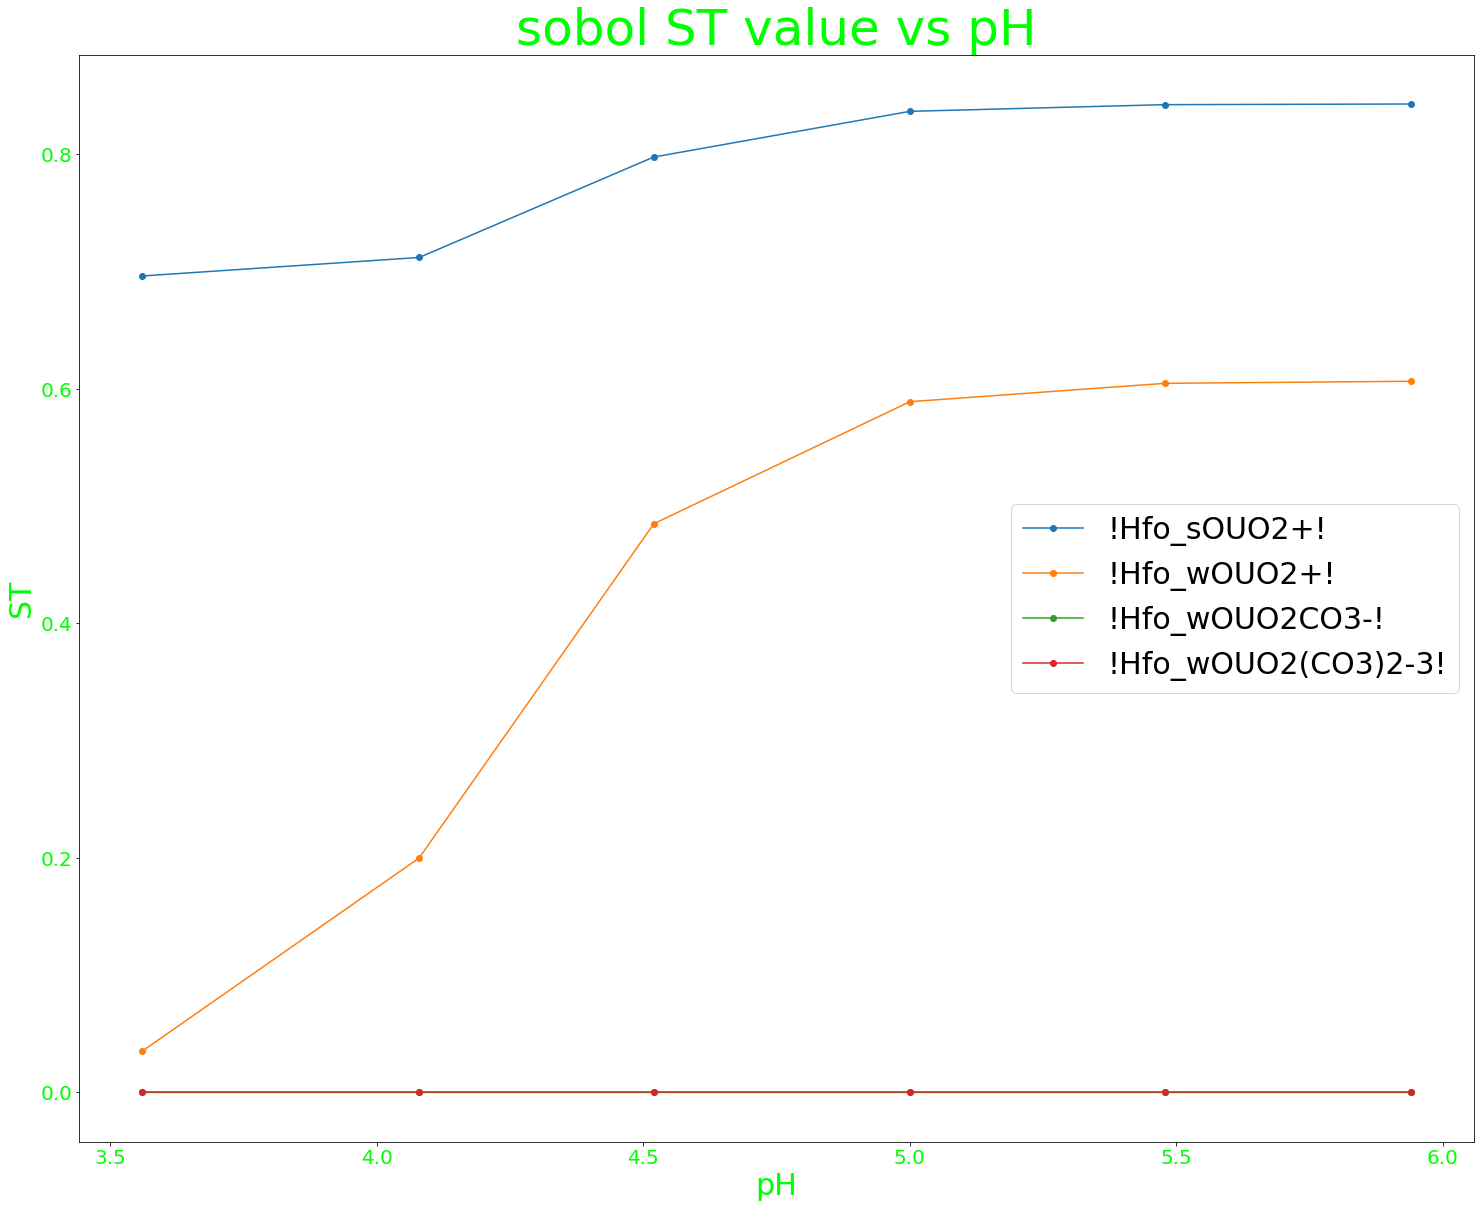

In [12]:
sb_st = dicts_to_mtrx(sr, "ST").T

f = plt.figure(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("sobol ST value vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('ST', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

for i in range(len(sb_st)):
    plt.plot(exp_pH, sb_st[i], marker='o', label="{}".format(pars[i]))
    plt.legend(fontsize=30)